# Imports

In [1]:
import model
from imports import *
from wrangle import wrangle_zillow

In [2]:
import warnings
warnings.filterwarnings('ignore')


# Wrangle Zillow

In [3]:
df=wrangle_zillow()

# df = [train_scaled, validate_scaled, test_scaled]

Using cached csv


In [4]:
df[0].head()

,beds,baths,sqft,property_value,year,taxes,fips
0,0.166667,0.06250,0.024666,578000.0,1978.0,0.006661,6059.0
1,0.222222,0.06250,0.024949,196335.0,1950.0,0.002501,6037.0
2,0.166667,0.06250,0.026786,186907.0,1947.0,0.002444,6037.0
3,0.166667,0.03125,0.018668,189154.0,1946.0,0.002720,6037.0
4,0.111111,0.03125,0.015183,229747.0,1929.0,0.003044,6037.0


In [5]:
ys=['property_value','taxes']


In [6]:
trunk=model.ml_data(df[0],df[1],df[2],target=ys)

#trunk = [X_train, y_train, X_validate, y_validate, X_test, y_test]

In [7]:
df=trunk[0]

with more time i would like to explore the outliers, possibly mung

In [ ]:
# def remove_outliers(df, k, col_list):
#     ''' 
#     This function remove outliers from a list of columns in a dataframe 
#     and returns that dataframe
#     '''
    
#     # Go through each column
#     for col in col_list:
        
#         # Get the quantiles
#         q1, q3 = df[col].quantile([.25, .75])
        
#         # Get the quantile range
#         iqr = q3 - q1
        
#         # Establish the upper and lower
#         upper_bound = q3 + k * iqr  
#         lower_bound = q1 - k * iqr   

#         # Redefine the DataFrame with removed outliers
#         df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
#     return df

In [ ]:
# df=remove_outliers(df,3,['beds','baths','sqft'])

In [8]:
df.info()

# 1278128 non-null

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1278128 entries, 0 to 1278127
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype   
---  ------  --------------    -----   
 0   beds    1278128 non-null  float64 
 1   baths   1278128 non-null  float64 
 2   sqft    1278128 non-null  float64 
 3   year    1278128 non-null  category
 4   fips    1278128 non-null  category
dtypes: category(2), float64(3)
memory usage: 32.9 MB


# 1

## LinearRegression (OLS)

In [9]:
y_train=trunk[1]

In [10]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1278128 entries, 0 to 1278127
Data columns (total 2 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   property_value  1278128 non-null  float64
 1   taxes           1278128 non-null  float64
dtypes: float64(2)
memory usage: 19.5 MB


In [11]:

y_train['yhat_base_prop']=y_train.median()[0]



In [12]:

y_train['yhat_base_taxes']=y_train.median()[1]



In [13]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1278128 entries, 0 to 1278127
Data columns (total 4 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   property_value   1278128 non-null  float64
 1   taxes            1278128 non-null  float64
 2   yhat_base_prop   1278128 non-null  float64
 3   yhat_base_taxes  1278128 non-null  float64
dtypes: float64(4)
memory usage: 39.0 MB


In [14]:
model = LinearRegression().fit(df[['sqft']],y_train['property_value'])



In [15]:
y_train['yhat_prop_ols'] = model.predict(df[['sqft']])

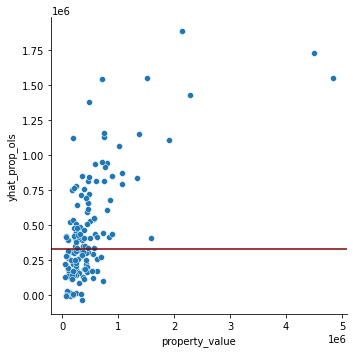

In [17]:
sns.relplot(y_train['property_value'].sample(150,random_state=7),y_train['yhat_prop_ols'].sample(150,random_state=7))
plt.axhline(y_train['yhat_base_prop'].iloc[0], c='maroon')

In [18]:
res=pd.DataFrame()

In [20]:
# compute residuals
res['residual_prop'] = y_train['yhat_prop_ols'] - y_train['property_value']
res['residual_base_prop'] = y_train['yhat_base_prop'] - y_train['property_value']

# df['yhat_prop'] - 
# res['residual_baseline'] = df['yhat_base_prop'] - y_train['property_value']


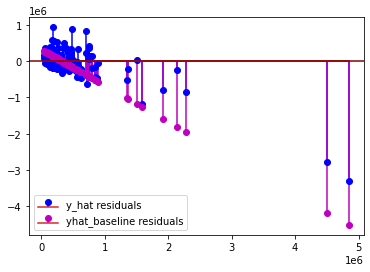

In [21]:
plt.stem(y_train['property_value'].sample(125,random_state=7),res['residual_prop'].sample(125,random_state=7),'bo',markerfmt='bo',label='y_hat residuals')
plt.stem(y_train['property_value'].sample(125,random_state=7),res['residual_base_prop'].sample(125,random_state=7),'mo',markerfmt='mo',label='yhat_baseline residuals')
plt.axhline(0, c='maroon')
plt.legend(loc='lower left')


In [22]:
y_train.head()

,property_value,taxes,yhat_base_prop,yhat_base_taxes,yhat_prop_ols
0,578000.0,0.006661,328632.5,0.004134,337026.899242
1,196335.0,0.002501,328632.5,0.004134,344698.183922
2,186907.0,0.002444,328632.5,0.004134,394561.534343
3,189154.0,0.002720,328632.5,0.004134,174225.191029
4,229747.0,0.003044,328632.5,0.004134,79612.679973


In [24]:
MSE2 = mean_squared_error(y_train.property_value, y_train.yhat_prop_ols)
MSE2_baseline = mean_squared_error(y_train.property_value, y_train.yhat_base_prop)


print("MSE sklearn: ","{:.2e}".format(MSE2)) 
print("MSE sklearn, baseline: ","{:.2e}".format(MSE2_baseline)) 


MSE sklearn:  2.84e+11
MSE sklearn, baseline:  4.73e+11


Our model did better than the baseline.

In [25]:
if MSE2-MSE2_baseline<0:
	print("y_hat superior")
else:
	print("yhat_baseline superior")	

y_hat superior


# 2

In [26]:
lars = LassoLars(alpha=1.0)

# create the model object


In [27]:
lars.fit(df[['sqft']], y_train.property_value)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series!


LassoLars()

In [28]:
y_train.head()

,property_value,taxes,yhat_base_prop,yhat_base_taxes,yhat_prop_ols
0,578000.0,0.006661,328632.5,0.004134,337026.899242
1,196335.0,0.002501,328632.5,0.004134,344698.183922
2,186907.0,0.002444,328632.5,0.004134,394561.534343
3,189154.0,0.002720,328632.5,0.004134,174225.191029
4,229747.0,0.003044,328632.5,0.004134,79612.679973


In [30]:
y_train['yhat_prop_lars'] = lars.predict(df[['sqft']])

# predict train

In [31]:

# evaluate: rmse
rmse_train = mean_squared_error(y_train.property_value, y_train.yhat_prop_lars)**(1/2)


In [ ]:

# predict validate
y_validate['G3_pred_lars'] = lars.predict(X_validate)


In [ ]:

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.G3, y_validate.G3_pred_lars)**(1/2)


In [32]:

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train)


RMSE for Lasso + Lars
Training/In-Sample:  533362.8612336772


In [ ]:
if rmse_train-MSE2_baseline<0:
	print("y_hat superior")
else:
	print("yhat_baseline superior")	

y_hat superior
